## W9 Handin

In [11]:
# Lets take a look at the content of the Iris dataset
import matplotlib
import matplotlib.pyplot as plt
from sklearn import datasets


iris = datasets.load_iris()
print(iris.data[0:1,:]) # show first line of matrix
print(len(iris.data),len(iris.target))
print(iris.target_names)
print(iris.target)
print(type(iris))

[[5.1 3.5 1.4 0.2]]
150 150
['setosa' 'versicolor' 'virginica']
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]
<class 'sklearn.utils.Bunch'>


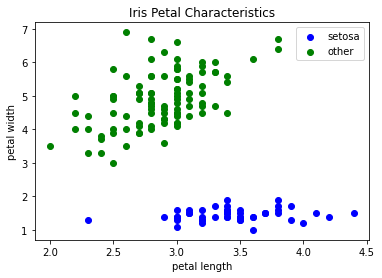

In [10]:
# Divide iris into setosa (target == 0) and not setosa
petal_length = iris.data[iris.target == 0][:,1]
petal_width = iris.data[iris.target == 0][:,2]
plt.scatter(petal_length, petal_width, c='b', label='setosa')

petal_length = iris.data[iris.target != 0][:,1]
petal_width = iris.data[iris.target != 0][:,2]
plt.scatter(petal_length, petal_width, c='g', label='other')

plt.title('Iris Petal Characteristics')
plt.xlabel('petal length')
plt.ylabel('petal width')

plt.legend()
plt.show()

In [7]:
import numpy as np
import pdb

def pla(training_data, no_iterations=10000, eta=0.5):
    """
    Find the proper weights to use in the perceptron based on data and target
    Parameters:
    training_data: list of vectors (features), as predictors zipped with a target value
    no_iterations: number of times to adjust the weights to get them as close as possible to the optimal number
    eta: the learning rate (prevent learning to go pendulum from one extreme error to the opposite)
    """
    
    dim = len(training_data[0][0]) # len = 2 (petal width and height)
    weights =  np.random.random(dim) # error and weights (for x and y) start out as random numbers
    
    # initial_error
    error = np.random.random()
    weight_history = [np.copy(weights)]

    for i in range(no_iterations):
        #pdb.set_trace()
        #breakpoint()
        inp_vec, expected_label = training_data[i % len(training_data)] # get the next feature set and label (start over after reaching end)
        perceptron_output = perceptron(inp_vec, weights) # perceptron output id a decimal between 0 and 1
        error = expected_label - perceptron_output       # error 
        weights += eta * error * inp_vec # accumulate the weights
        weight_history.append(np.copy(weights))
        
    return weights, weight_history 
        

learned_weights, weight_history = pla(trainings_data)
# print(weight_history)
print(learned_weights)
print('training data', trainings_data)

NameError: name 'trainings_data' is not defined